In [1]:
!pip install keras-tuner

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_2992/1465740557.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [38]:
# CIFAR-10 데이터셋 로딩
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [39]:
y_test.shape

(10000, 1)

In [40]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [41]:
# 2. 인덱스 리스트
indices = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792,
           1227, 5191, 5690, 1718, 2592, 4794, 5960, 165,
           9227, 5632, 9352, 7846, 6966, 5468]

In [42]:
# 3. 선택된 레이블
y_selected = [y_test[i] for i in indices]

# 4. 정수 라벨로 변환
label_numbers = [int(label[0]) for label in y_selected]

# 5. 클래스 이름으로 변환
label_names = [class_names[i] for i in label_numbers]

print(label_names)

['cat', 'airplane', 'deer', 'airplane', 'bird', 'automobile', 'cat', 'cat', 'cat', 'cat', 'horse', 'airplane', 'bird', 'deer', 'bird', 'deer', 'automobile', 'cat', 'automobile', 'frog', 'airplane', 'dog']


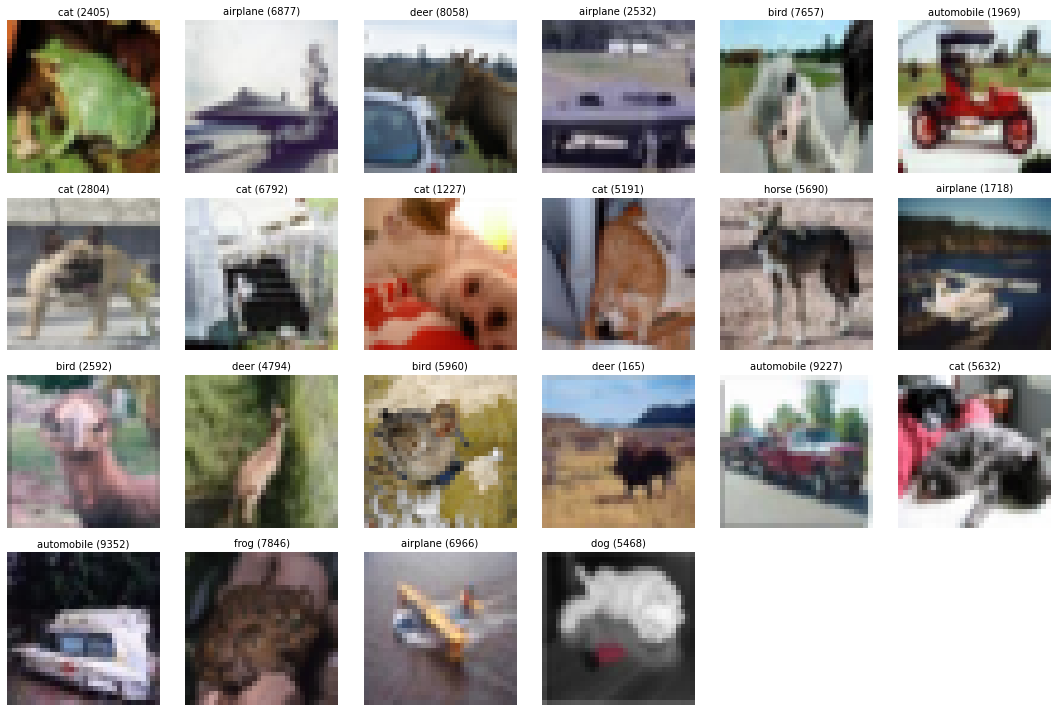

In [43]:
# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 인덱스 리스트
indices = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792,
           1227, 5191, 5690, 1718, 2592, 4794, 5960, 165,
           9227, 5632, 9352, 7846, 6966, 5468]

# 시각화 함수
def show_images(images, labels, indices, class_names, rows=4, cols=6):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        
        # 정수 라벨 (예: [[3]])일 경우 대비
        label = labels[idx]
        if isinstance(label, (np.ndarray, list)) and len(label) > 1:
            label = np.argmax(label)
        elif isinstance(label, (np.ndarray, list)):
            label = label[0]
        
        plt.title(f"{class_names[label]} ({idx})", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
show_images(x_test, y_test, indices, class_names)

In [44]:
Cleanlab_lab = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]

for idx, new_label in zip(indices, Cleanlab_lab):
    y_test[idx][0] = new_label  # one-hot 벡터로 바꿈

In [45]:
# 3. 선택된 레이블
y_selected = [y_test[i] for i in indices]

# 4. 정수 라벨로 변환
label_numbers = [int(label[0]) for label in y_selected]

# 5. 클래스 이름으로 변환
label_names = [class_names[i] for i in label_numbers]

print(label_names)

['frog', 'ship', 'horse', 'automobile', 'horse', 'truck', 'dog', 'truck', 'dog', 'dog', 'deer', 'ship', 'deer', 'bird', 'cat', 'bird', 'truck', 'dog', 'truck', 'cat', 'ship', 'cat']


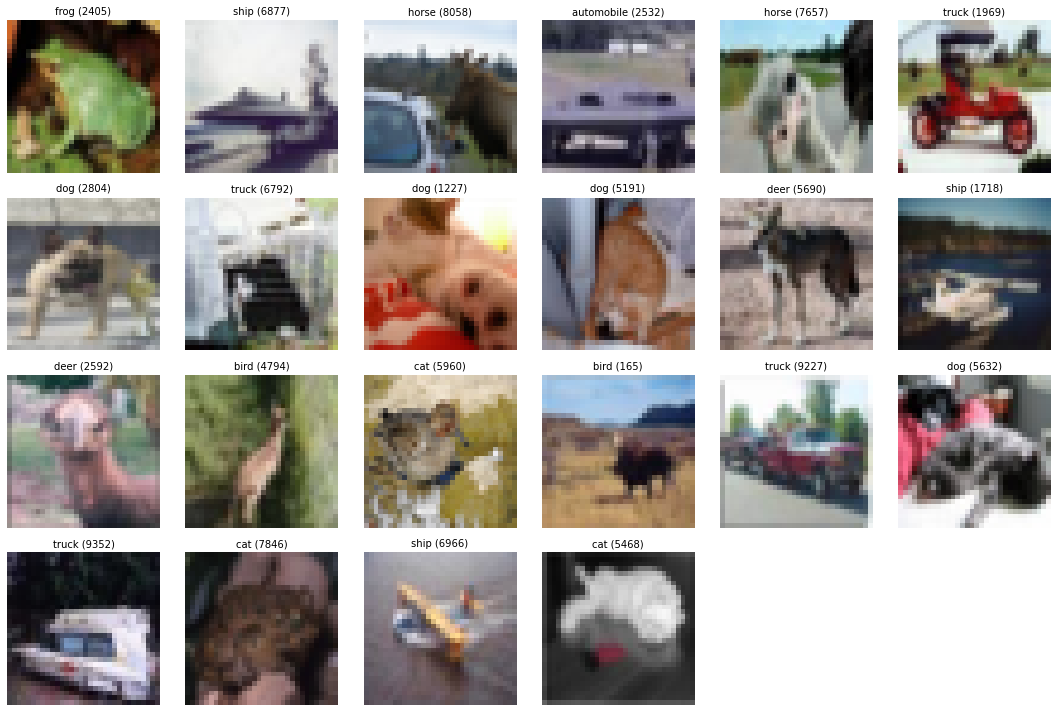

In [46]:
# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 인덱스 리스트
indices = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792,
           1227, 5191, 5690, 1718, 2592, 4794, 5960, 165,
           9227, 5632, 9352, 7846, 6966, 5468]

# 시각화 함수
def show_images(images, labels, indices, class_names, rows=4, cols=6):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        
        # 정수 라벨 (예: [[3]])일 경우 대비
        label = labels[idx]
        if isinstance(label, (np.ndarray, list)) and len(label) > 1:
            label = np.argmax(label)
        elif isinstance(label, (np.ndarray, list)):
            label = label[0]
        
        plt.title(f"{class_names[label]} ({idx})", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
show_images(x_test, y_test, indices, class_names)

In [47]:
# 정규화 및 원-핫 인코딩
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print(X_train.shape)

(40000, 32, 32, 3)


In [49]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(30, 30, 3)))

    # Conv block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Conv block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    # Dense
    dense_units = hp.Choice('dense_units', values=[128, 256, 512])
    model.add(layers.Dense(dense_units, activation='relu'))

    # Dropout
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [50]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='cifar10_dropout_tune'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10
)

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.692300021648407

Best val_accuracy So Far: 0.7178999781608582
Total elapsed time: 00h 14m 59s


In [51]:
# 최적 하이퍼파라미터
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best dense_units:", best_hp.get('dense_units'))
print("Best dropout_rate:", best_hp.get('dropout_rate'))

Best dense_units: 256
Best dropout_rate: 0.4


In [52]:
# 최적 모델 생성
model = build_model(best_hp)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [53]:
# 재학습 (선택)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6092 - accuracy: 0.4672 - val_loss: 1.3777 - val_accuracy: 0.5023
Epoch 2/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1221 - accuracy: 0.6071 - val_loss: 1.1918 - val_accuracy: 0.5774
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9447 - accuracy: 0.6694 - val_loss: 0.9614 - val_accuracy: 0.6645
Epoch 4/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8225 - accuracy: 0.7121 - val_loss: 1.1264 - val_accuracy: 0.6318
Epoch 5/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7223 - accuracy: 0.7444 - val_loss: 0.9826 - val_accuracy: 0.6736
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6311 - accuracy: 0.7771 - val_loss: 0.9466 - val_accuracy: 0.6749
Epoch 7/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5489 - accuracy: 0.8052 - val_loss: 0.9613 - val_accuracy:

In [54]:
# 테스트 평가
loss, acc = model.evaluate(x_test, y_test)
print("Test accuracy:", acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.5012 - accuracy: 0.7189
Test accuracy: 0.7189000248908997


In [55]:
save_path = os.getenv('HOME') + '/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/mlops/best_model/1/model/assets


In [56]:
load_path = os.getenv('HOME') + '/mlops/best_model/1/model'
best_model = tf.keras.models.load_model(load_path)

In [57]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [60]:
# TensorFlow Serving용으로 저장 (SavedModel 형식)
model.save("exported_model/1")  # "1"은 버전명 (필수!)

INFO:tensorflow:Assets written to: exported_model/1/assets
